**Наша задача:**
Построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

В базовом решении метрика MAPE была 14.13.
Решение включало в себя заполнение значением "0" пустых значений в признаках lat и lng, и удалением всех признаков типа "object".

Попробуем улучшить результат.

In [ ]:
pip install nltk[twitter] 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# инструмент для обработки текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.download('vader_lexicon')


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Знакомство с данными

In [3]:
# Загрузим данные

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [6]:
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


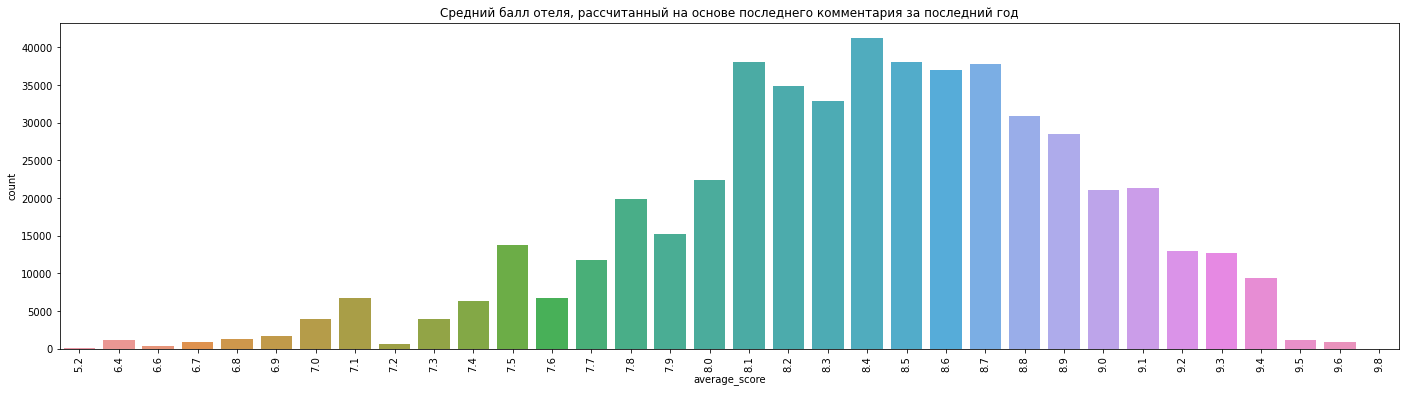

In [7]:
# посмотрим на выставленные оценки отелям. признак average_score
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
ax = sns.countplot(x=data.average_score)
ax.set_title("Cредний балл отеля, рассчитанный на основе последнего комментария за последний год")
plt.show()

При первом взгляде на данные я вижу, что пустые значения только у двух признаков lat и lng.

А так же большое количество категориальных признаков, которые нельзя подать на вход нашей модели.

Среди интересных признаков, которые могут иметь большой вес в формировании рейтинга отеля, я бы выделила:

* **negative_review**, **positive_review** - собственно негативный и положительный отзывы. 

* **review_date** (object) - дата, когда отзыв был размещен. этот признак перекликается с **days_since_review** (object) - сколько дней отзыву.


# 2. Очистка данных

Пустые значения в двух признаках lat и lng - широта и долгота отеля, заполним значением "0".

In [8]:
# из базового решения подготовки данных. ВНИМАНИЕ! так 0 заполнится весь столбец полностью, а не только пустые значения!
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

# буду заполнять "0" ТОЛЬКО None-ы
data['lat'].fillna(0, inplace=True)
data['lng'].fillna(0, inplace=True)

In [ ]:
# Удаление дубликатов показало улучшение метрики на сотую долю. Но на Kaggle проводить ее не буду, а то 
# поедет вся отчетность. Т.к. в загружаемой таблице sample_submission из файла submission.csv присутствуют 
# и удаленные на этапе удаления дубликатов айдишники. Не сможем загрузить туда наши предсказанные рутинги, т.к.
# не будут совпадать len(predict_submission)    - 128906   и   len(sample_submission)   - 128935.


# ищем и удаляем дубликаты
#print(f'Число записей: {data.shape[0]}')

#dupl_columns = list(data.columns)

# создали маску дубликатов и производим фильтрацию
#mask_d = data.duplicated(subset=dupl_columns)
#data_duplicates = data[mask_d]
#print(f'Число найденных полных дубликатов: {data_duplicates.shape[0]}')

#data = data.drop_duplicates(subset=dupl_columns)#, inplace=True, ignore_index=True)
#print(f'Результирующее число записей: {data.shape[0]}')

# 3. Исследование и проектирование признаков

## - Признак **hotel_name**

In [9]:
# дело будем иметь с 1492 отелями
print('дело будем иметь с ', data['hotel_name'].unique().shape[0], ' отелями')

# попробуем get_dummies. Получилось 1509 колонов в датасете!
#cols_for_coding = ['hotel_name']
#encoded_hotel_name = pd.get_dummies(data, columns = cols_for_coding)

# закодируем названия отелей OrdinalEncoder()
encoder = ce.OrdinalEncoder()
data['hotel_name_eo'] = encoder.fit_transform(data[['hotel_name']])
#data = pd.concat([data, data_bin], axis = 1)

дело будем иметь с  1492  отелями


In [10]:
data[['hotel_name', 'hotel_name_eo']]

,hotel_name,hotel_name_eo
0,Hotel Da Vinci,1
1,Urban Lodge Hotel,2
2,Alexandra Barcelona A DoubleTree by Hilton,3
3,Hotel Principe Di Savoia,4
4,Hotel Esther a,5
...,...,...
515733,Hotel Moonlight,725
515734,BEST WESTERN PLUS Amedia Wien,925
515735,Bloomsbury Palace Hotel,272
515736,The Marble Arch London,189


## - Признак **negative_review** и **positive_review**

In [11]:
data['negative_review'].value_counts()

No Negative                                                                                                                                                                                                             127890
 Nothing                                                                                                                                                                                                                 14295
 Nothing                                                                                                                                                                                                                  4236
 nothing                                                                                                                                                                                                                  2225
 N A                                                                                                        

По сути наш отзыв состоит из двух частей: "Что понравилось?" и "Что не понравилось?" Поэтому положительный отзыв может содержать в столбце "negative_review" значение "No Negative", т.е. там тоже будет что-то написано.

Я хочу проанализировать признаки с отзывами с помощью **SentimentIntensityAnalyzer** из библиотеки **nltk**. 

In [12]:
sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
# пример работы функции

rev1 = "Cleanliness the walls are dirty Battery sink it s too short you can not wash No wardrobe in the room "
rev2 = "No Negative"
rev3 = "nothing"
rev4 = "small room"
rev5 = "negative review small room"
rev6 = "nothing really"
rev7 = "bad price"

rev8 = "no positive"
rev9 = "location"


print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")

print(f"\nreview 3:\n{rev3}\nScore: {sent_analyzer.polarity_scores(rev3)}")

print(f"\nreview 4:\n{rev4}\nScore: {sent_analyzer.polarity_scores(rev4)}")

print(f"\nreview 5:\n{rev5}\nScore: {sent_analyzer.polarity_scores(rev5)}")

print(f"\nreview 6:\n{rev6}\nScore: {sent_analyzer.polarity_scores(rev6)}")

print(f"\nreview 7:\n{rev7}\nScore: {sent_analyzer.polarity_scores(rev7)}")

print(f"\nreview 8:\n{rev8}\nScore: {sent_analyzer.polarity_scores(rev8)}")

print(f"\nreview 9:\n{rev9}\nScore: {sent_analyzer.polarity_scores(rev9)}")

In [13]:
# приведем отзывы к нижнему регистру
data['negative_review'] = data['negative_review'].str.lower()
data['positive_review'] = data['positive_review'].str.lower()

data['negative_review'] = data['negative_review'].str.strip()
data['positive_review'] = data['positive_review'].str.strip()

In [ ]:
data['negative_review'].value_counts().head(50)

In [ ]:
data['positive_review'].value_counts().head(50)

Дополнительно поработаю с отзывами. Есть очень большой кусок отзывов типа "no negative" - 127890 записей, а также "nothing", "none", "n a" и т.п. Тоже самое в положительных отзывах.

Еще заметила такую вещь: "No negative" **в отрицательном отзыве** несет негативную окраску! 
No Negative
Score: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

Это неправильно. Надо заменить на противоположное.
Также надо убрать неоднозначность отзыва "no positive" в признаке с положительными отзывами.


In [14]:
# функция для причесывания признака с НЕГАТИВНЫМИ отзывами negative_review
def negative_review_clean (review_str):
    # строки с противоположным значением
    string_for_change = ['no negative', 'nothing', 'n a', 'no', 'none', '', 'na', 'nil', 'non', 'nothing really', 'all good', 'nothing to dislike']
    if review_str in string_for_change: return 'positive'
    return review_str



# функция для причесывания признака с ПОЛОЖИТЕЛЬНЫМИ отзывами positive_review
def positive_review_clean (review_str):
    string_for_change = ['no positive', 'nothing', '']
    if review_str in string_for_change: return 'negative'
    return review_str


data['negative_review_cleaned'] = data['negative_review'].apply(negative_review_clean)
data['positive_review_cleaned'] = data['positive_review'].apply(positive_review_clean)

In [ ]:
data['negative_review_cleaned'].value_counts().head(50)

In [ ]:
data['positive_review_cleaned'].value_counts().head(50)

In [15]:
# анализируем негативные отзывы
data['negative_review_nltk'] = data['negative_review_cleaned'].apply(lambda x: sent_analyzer.polarity_scores(x))

# анализируем позитивные отзывы
data['positive_review_nltk'] = data['positive_review_cleaned'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [16]:
# после анализатора получаем признаки со словарями. сформируем из них новые признаки по ключам словарей

data['negative_review_neg'] = data['negative_review_nltk'].apply(lambda x: x['neg'])
data['negative_review_neu'] = data['negative_review_nltk'].apply(lambda x: x['neu'])
data['negative_review_pos'] = data['negative_review_nltk'].apply(lambda x: x['pos'])
data['negative_review_compound'] = data['negative_review_nltk'].apply(lambda x: x['compound'])

data['positive_review_neg'] = data['positive_review_nltk'].apply(lambda x: x['neg'])
data['positive_review_neu'] = data['positive_review_nltk'].apply(lambda x: x['neu'])
data['positive_review_pos'] = data['positive_review_nltk'].apply(lambda x: x['pos'])
data['positive_review_compound'] = data['positive_review_nltk'].apply(lambda x: x['compound'])

## - Признаки review_total_negative_word_counts и review_total_positive_word_count

При анализе тональности отзыва библиотекой nltk методом polarity_scores, выяснилось, что **отзыв в одно слово** имеет нейтральную окраску.
Например, "location" - 
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
или "staff". А нам нужен конкретный результат: если такой односложный отзыв будет в негативном отзыве - нам нужно, чтобы он нес neg-окрас, в положительном отзыве - pos-окрас.

Для этого мы вручную увеличим вес таких признаков, например, на 0.5 (не крайняя степень эмоционального окраса, т.к. если бы отзыв был более эмоциональный, в нем было бы больше одного слова). Для определения количества слов в отзыве возьмем готовые признаки из датафейма **review_total_negative_word_counts** и **review_total_positive_word_count**

In [ ]:
data[data['negative_review_cleaned'] == 'staff'][['negative_review', 'positive_review' ,'negative_review_neg', 'positive_review_pos','review_total_negative_word_counts']].head(59)


In [17]:
# функции по замене эмоционального окраса у отзывов в одно слово, кроме тех, что мы уже исправили на positive
# ищем не == 1, а <=3 т.к. почему-то в датафрейме у отзыва в одно слово review_total_negative_word_counts 
# и review_total_positive_word_counts  посчитано как 2

def more_neg (x, y, z):
    if x != 'positive' and y<=3: return 0.5
    return z

def more_pos (x, y, z):
    if x != 'negative' and y<=3: return 0.5
    return z

# вызов функций
data['negative_review_neg'] = data.apply(lambda row: more_neg(row['negative_review_cleaned'], row['review_total_negative_word_counts'], row['negative_review_neg']), axis=1)

data['positive_review_pos'] = data.apply(lambda row: more_neg(row['positive_review_cleaned'], row['review_total_positive_word_counts'], row['positive_review_pos']), axis=1)

## - Признак **review_date**

In [18]:
# преобразуем признак даты в тип датавремя
data['review_date'] = pd.to_datetime(data['review_date'])
print('Самый свежий отзыв оставлен', data['review_date'].max())
print('Первый отзыв оставлен', data['review_date'].min())

Самый свежий отзыв оставлен 2017-08-03 00:00:00
Первый отзыв оставлен 2015-08-04 00:00:00


Моделе нельзя подать данные типа datetime, она их не поймет,но в нашем датасете есть признак **days_since_review**. В котором уже посчитано количество дней с написания отзыва. Его и будем использовать, только приведем к типу int, а от **review_date** избавимся.

In [19]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['days_since_review'].head(5)

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int64

## - Признак hotel_address

Этот признак типа object. Выделим из него наиболее часто встречающиеся города, в которых расположены отели и закодируем этот категориальный признак.

In [20]:
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2]) # берем второй элемент с конца, там название города
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)

# сделаем тоже для страны
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1]) # берем первый элемент с конца, там название страны

# кодируем информацию
data['city'] = data['city'].astype('category')
data['city_cat'] = data['city'].cat.codes

data['country'] = data['country'].astype('category')
data['country_cat'] = data['country'].cat.codes

In [ ]:
data['city'].value_counts(), data['country'].value_counts()

## - Признак reviewer_nationality

In [21]:
# очистим
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

print('В нашем датасете отзывы написаны людьми из ', data['reviewer_nationality'].value_counts().shape[0], ' стран.')

print('Топ-50 стран, кем написаны отзывы: ', data['reviewer_nationality'].value_counts().head(50))

# т.к. стран очень много, закодируем эти данные Двоичным кодированием. оно не так сильно раздует датасет, увеличив
# его на 8 дополнительных стобцов
import category_encoders as ce

bin_encoder = ce.BinaryEncoder(cols = ['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

В нашем датасете отзывы написаны людьми из  227  стран.
Топ-50 стран, кем написаны отзывы:  United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
India                         3437
Greece                        3406
China                         3400
Sweden                        3368
New Zealand                   3237
Singapore                     309

## - Признак tags

In [150]:
data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                   5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                            3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                  3291
                                                                                                                                                          ... 
[' Leisure trip ', ' Couple ', ' Superior Quee

In [ ]:
#def unique_tags (arg):
#    arg = arg[2:-2]
#    res = arg.strip().split(' \', \' ')
#    return res

#data['new_tags'] = data['tags'].apply(unique_tags)
#data = data.explode('new_tags')
#print(len(data['new_tags'].unique()))

#data['new_tags'].value_counts()

## - Признак total_number_of_reviews_reviewer_has_given

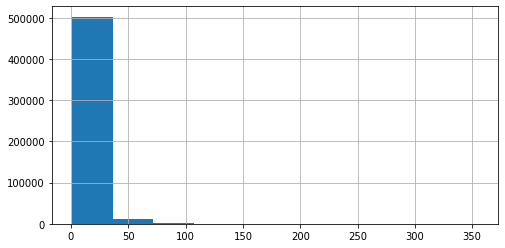

In [22]:
# Посморим на распределение признака
plt.figure(figsize=(8,4))
data['total_number_of_reviews_reviewer_has_given'].hist()
plt.title('');

In [ ]:
# логирифмирую все в одном месте дальше
#data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].apply(
#    lambda x: np.log(x+1))

# 4. Распределение признаков

In [137]:
# первым делом скопируем датасет
data_for_fit = data.copy()

In [138]:
# и убираем признаки типа "object"
object_columns = [s for s in data_for_fit.columns if ((data_for_fit[s].dtypes == 'object') | (data_for_fit[s].dtypes == 'datetime64[ns]') | (data_for_fit[s].dtype.name == 'category'))]
print('Удалили ', len(object_columns), ' признаков')
data_for_fit.drop(object_columns, axis = 1, inplace=True)

Удалили  13  признаков


In [139]:
data_for_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Посмотрим как распределены признаки.

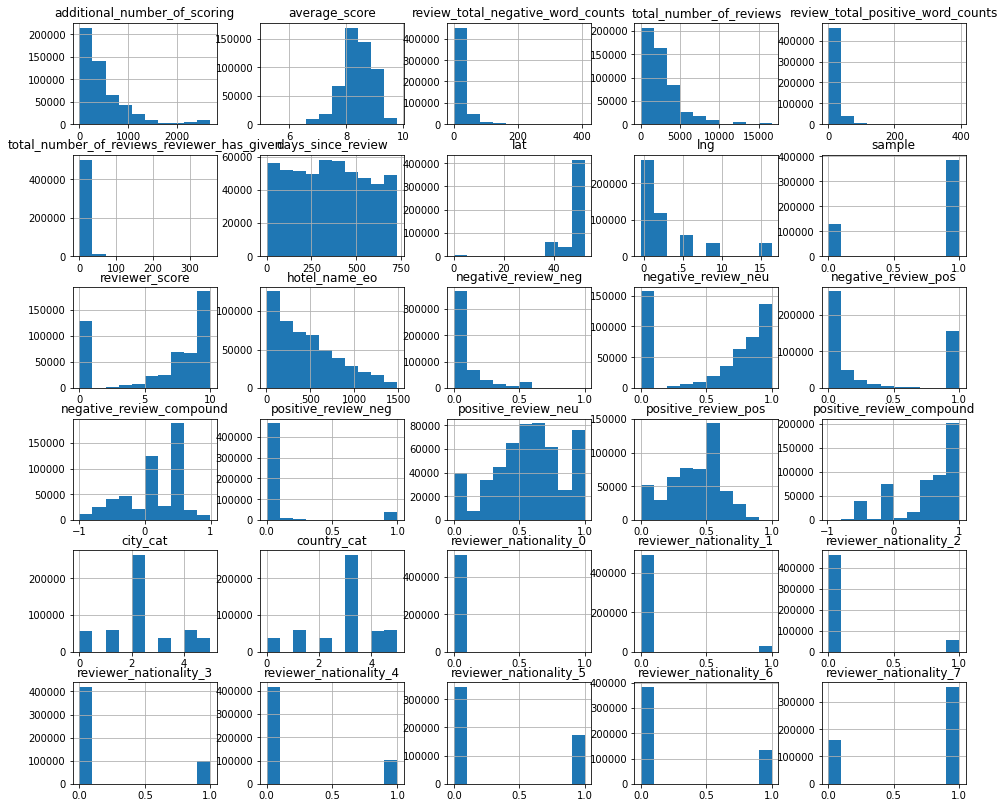

In [27]:
data_for_fit.hist(figsize=(16,14));

In [103]:
# некоторые признаки мы можем логарифмировать, так их распределение станет более нормальным
data_for_fit['total_number_of_reviews_reviewer_has_given'] = data_for_fit['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: np.log(x+1))

data_for_fit['review_total_negative_word_counts'] = data_for_fit['review_total_negative_word_counts'].apply(
    lambda x: np.log(x+1))

data_for_fit['review_total_positive_word_counts'] = data['review_total_positive_word_counts'].apply(
    lambda x: np.log(x+1))

#data_for_fit['negative_review_neg'] = data_for_fit['negative_review_neg'].apply(lambda x: np.log(x+1))

#data_for_fit['positive_review_neg'] = data_for_fit['positive_review_neg'].apply(lambda x: np.log(x+1))

data_for_fit['additional_number_of_scoring'] = data_for_fit['additional_number_of_scoring'].apply(
    lambda x: np.log(x+1))

data_for_fit['total_number_of_reviews'] = data_for_fit['total_number_of_reviews'].apply(
    lambda x: np.log(x+1))

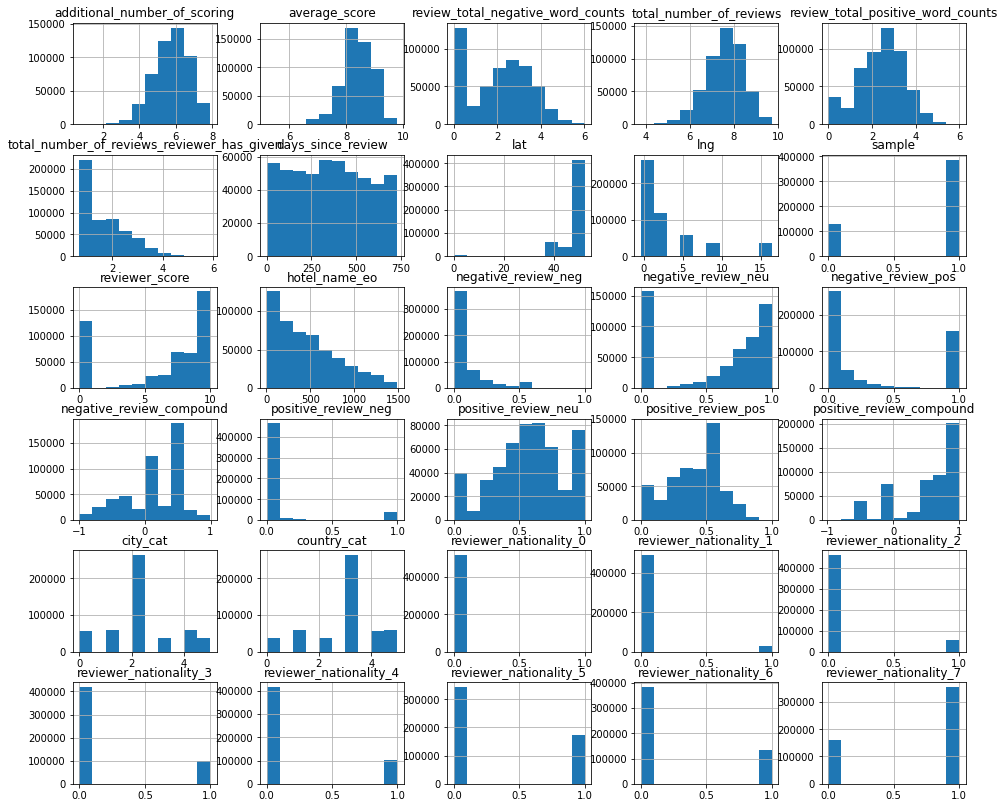

In [29]:
# после логарифмирования
data_for_fit.hist(figsize=(16,14));

Некоторые признаки прекрасно были логиарифмированны (total_number_of_reviews_reviewer_has_given, review_total_negative_word_counts, review_total_positive_word_counts) и распределения этих признаков стали более нормальные.

Но построение модели на НЕлогарифмированных признаках показало лучшую метрику по сравнению с логарифмированными признаками.

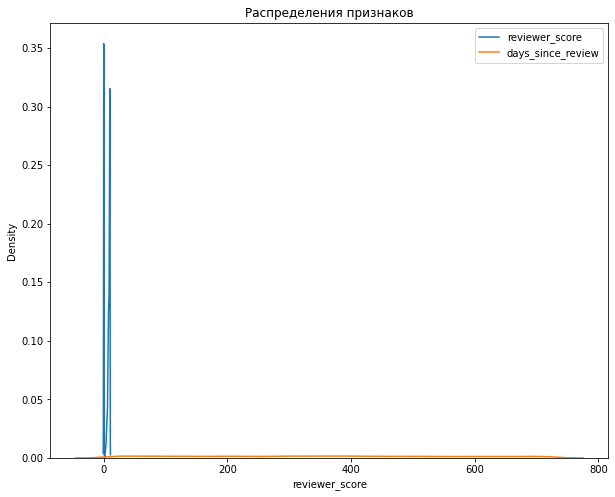

In [30]:
# какие еще признаки можно нормализовать
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10,8))
ax1.set_title('Распределения признаков до нормальзации')

sns.kdeplot(data_for_fit['reviewer_score'], ax = ax1, label='reviewer_score')
sns.kdeplot(data_for_fit['days_since_review'], ax = ax1, label='days_since_review')

plt.legend()

Построив этот график (выше), я обратила внимание на "days_since_review". У него самые большие значения. Вес этого признака для модели может быть неверный. Шкалируем его

In [104]:
data_mm = MinMaxScaler().fit_transform(data_for_fit)

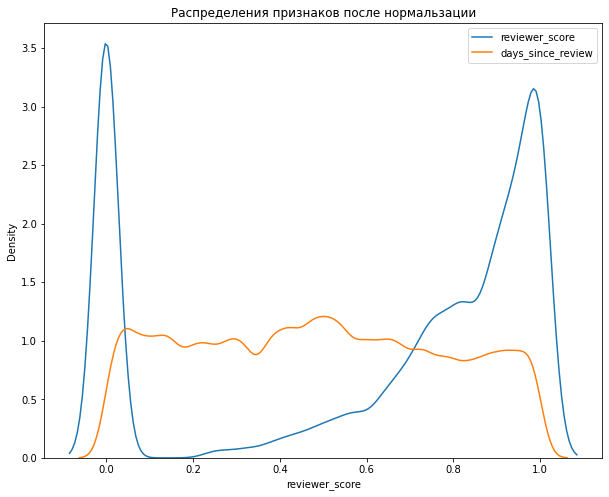

In [105]:
col_names = list(data_for_fit.columns)
data_mm = pd.DataFrame(data_mm, columns = col_names)
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10,8))
ax1.set_title('Распределения признаков после нормальзации')

sns.kdeplot(data_mm['reviewer_score'], ax = ax1, label='reviewer_score')
sns.kdeplot(data_mm['days_since_review'], ax = ax1, label='days_since_review')

plt.legend()

In [106]:
data_for_fit = data_mm.copy()

# 5. Отбор признаков

In [79]:
data_for_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  float64
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  float64
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   days_since_review                           515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  float64
 

In [97]:
# разделим признаки

# категориальные
cat_cols = ['average_score','additional_number_of_scoring', 'hotel_name_eo', 'total_number_of_reviews',
            'reviewer_nationality_0','reviewer_nationality_1','reviewer_nationality_2',
            'reviewer_nationality_3','reviewer_nationality_4','reviewer_nationality_5',
            'reviewer_nationality_6','reviewer_nationality_7',
            'city_cat', 'country_cat'
            ]

# числовые
num_cols = ['review_total_negative_word_counts', 
           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
           'days_since_review', 'lat', 'lng',
            
            'negative_review_neg', 'negative_review_neu', 'negative_review_pos','negative_review_compound', 
            'positive_review_neg', 'positive_review_neu', 'positive_review_pos','positive_review_compound'
           ]

# в списки не включаю sample и reviewer_score



## - Проверка на корреляцию

<AxesSubplot:>

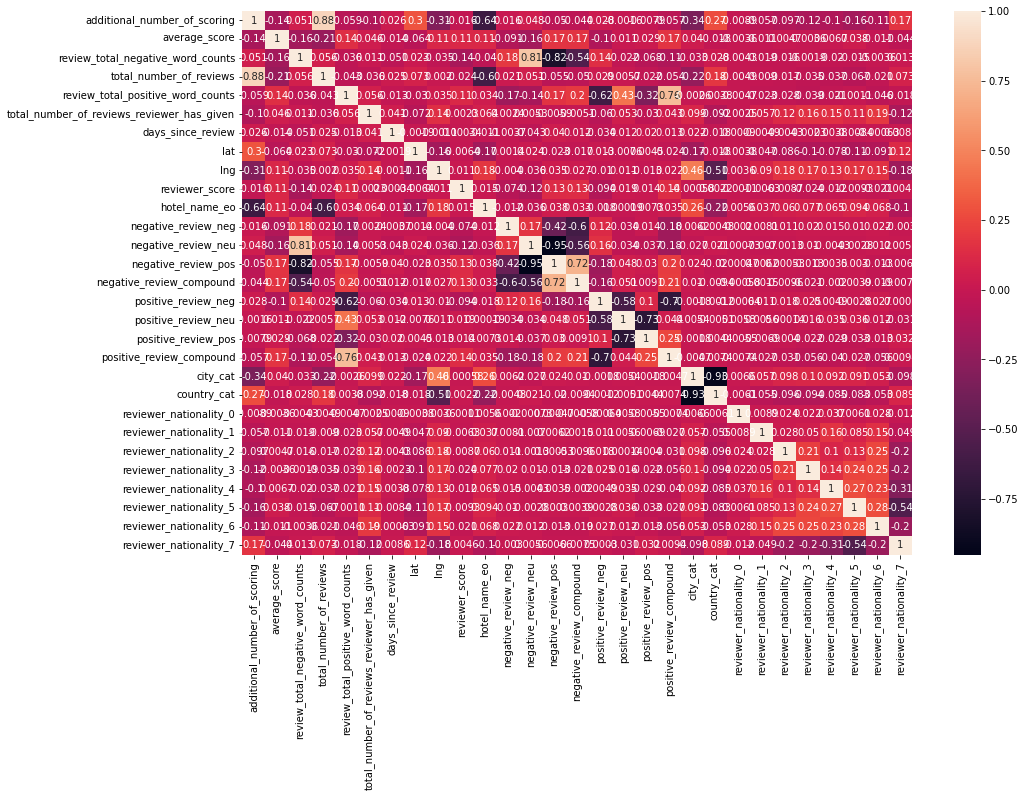

In [107]:
# для корреляции с непрерывными признаками будем использовать метод Пирсона
#corr = data.corr(method='pearson')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_for_fit.drop(['sample'], axis=1).corr(method = 'pearson'), annot=True)

<AxesSubplot:>

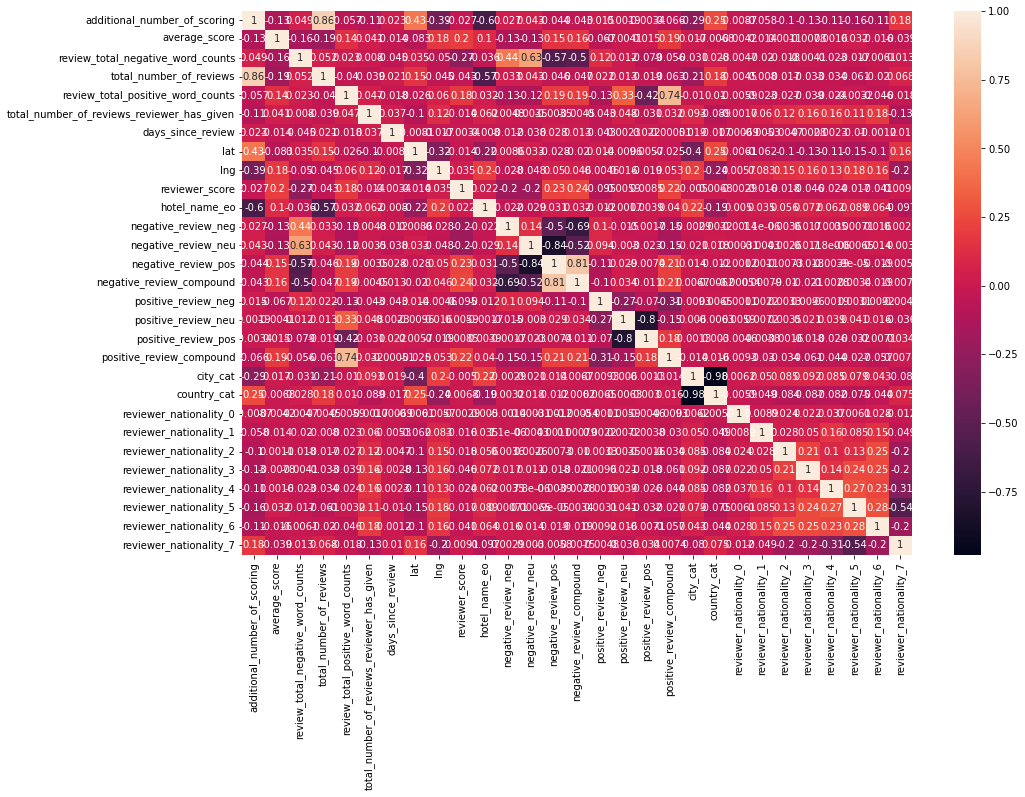

In [108]:
# Для корреляции с категориальными признаками будем использовать метод Спирмена
#corr = data.corr(method = 'spearman')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_for_fit.drop(['sample'], axis=1).corr(method = 'spearman'), annot=True)

In [111]:
# удалим сильно коррелирующие признаки
data_for_fit.drop(['additional_number_of_scoring', 'country_cat', 'negative_review_compound',
                  'positive_review_compound'],axis=1,inplace=True)

**Вот тут очень интересно! Если я удаляю коррелирующие признаки, метрика ухудшается. После вывода (график ниже, после обучения модели) наиболее важных для модели признаков видно, что как раз positive_review_compound и negative_review_pos - являются самыми важными на данном этапе.**

<AxesSubplot:>

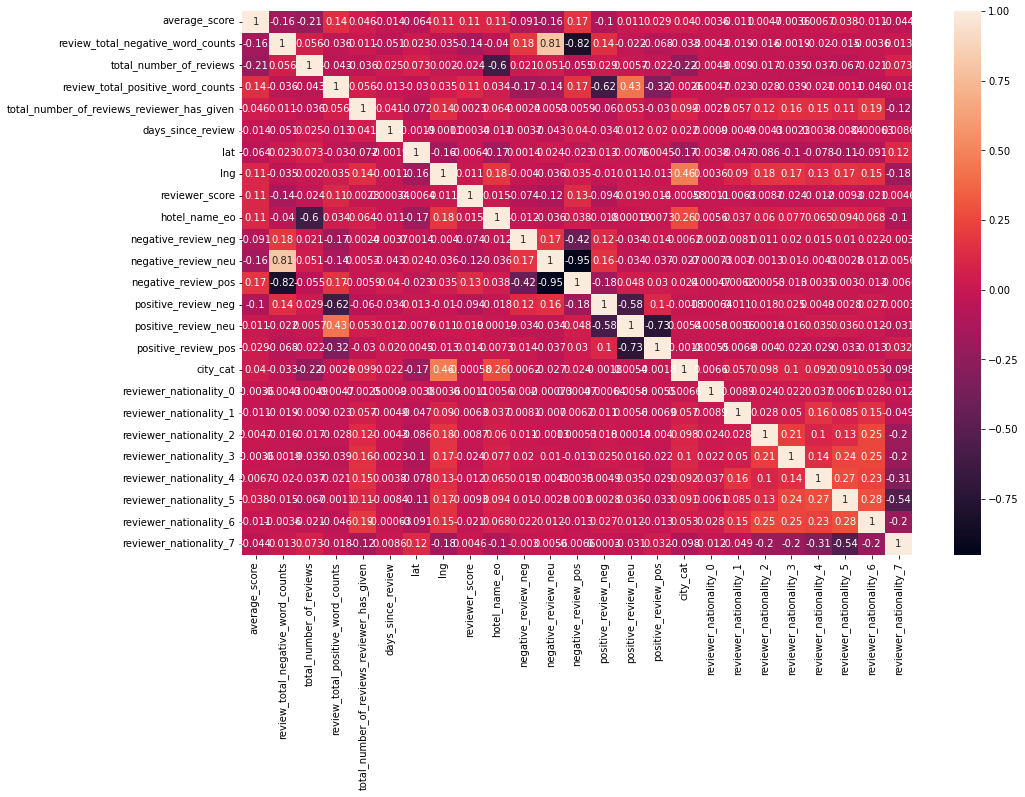

In [112]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_for_fit.drop(['sample'], axis=1).corr(), annot=True)

## - Оценка значимости признаков

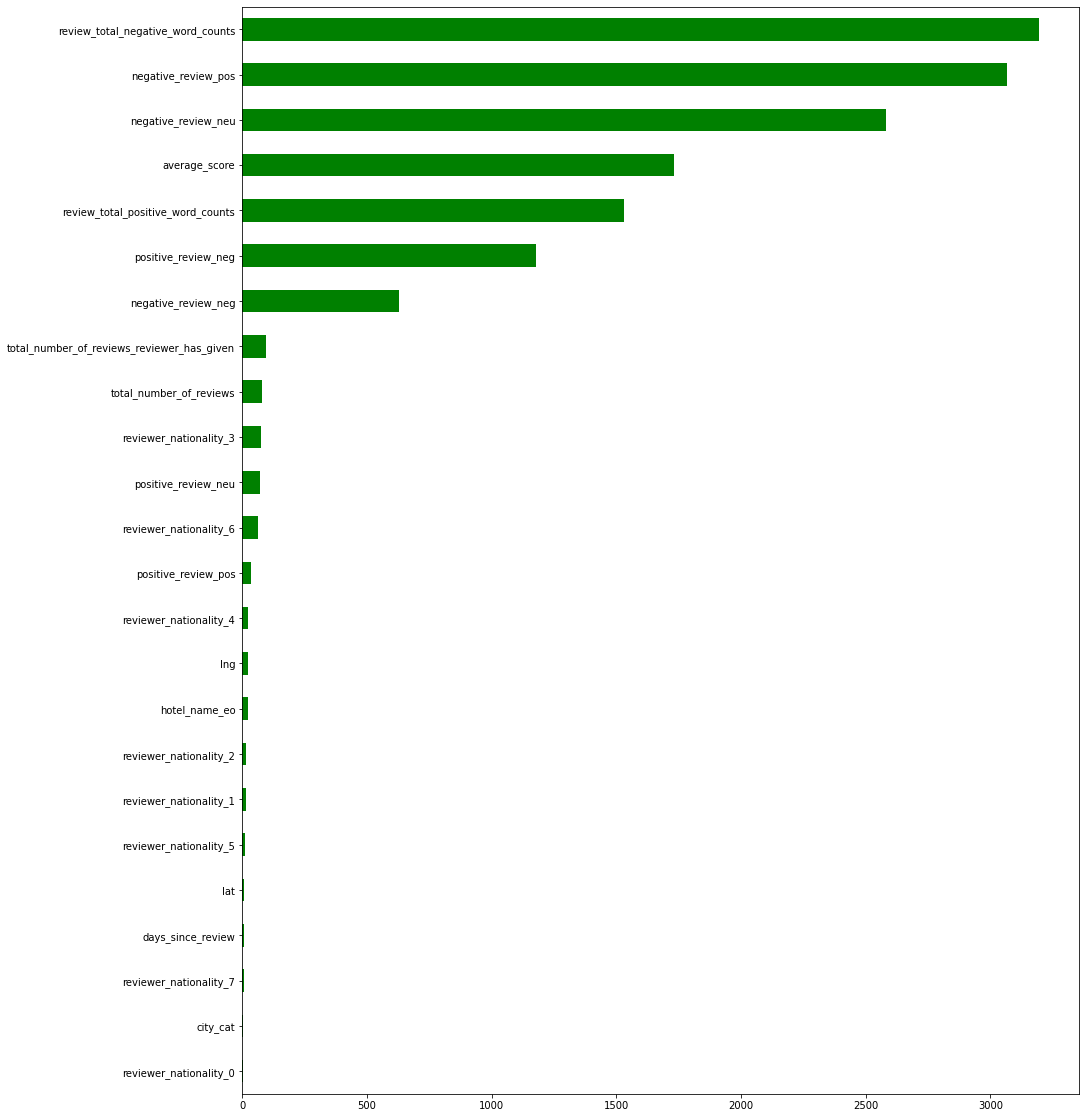

In [113]:
# влияние признаков на модель
from sklearn.feature_selection import f_classif 

y = data_for_fit.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data_for_fit.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [114]:
# удалим не оказывающие влияние на модель признаки
data_for_fit.drop(['reviewer_nationality_0'],axis=1,inplace=True)

In [141]:
data_for_fit.drop(['hotel_name_eo', 'city_cat', 'country_cat'],axis=1,inplace=True)

In [142]:
data_for_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

## - Подготовка признаков для обучения модели

In [143]:
# Теперь выделим тестовую часть
train_data = data_for_fit.query('sample == 1').drop(['sample'], axis=1)
test_data = data_for_fit.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [144]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [145]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (386803, 26), (386803, 25), (309442, 25), (77361, 25))

In [37]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [146]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [147]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: user 11min 58s, sys: 1.38 s, total: 11min 59s
Wall time: 3min 4s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [148]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8700460816358183


MAE: 0.9822361453527125

MAE: 0.8859467676279675

MAE: 0.8751891869041921

MAE: 0.8700941278089547

In [149]:
# MAPE метрика - средняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.38


1. При первой обработке (заменили все lat и lng "0". и удалили все object) получили MAPE: 14.13
2. Если еще и избавиться от дубликатов метрика MAPE: 14.12
3. После удаления дублей, пустых значений (оба столбца lat и lng) и преобразовав признаки с отзывами получили MAPE: 12.64
4. если не удалять lat/lng, и не удалять дубликаты - MAPE: 12.7
5. если удалять коррелирующие признаки MAPE: 12.56. **Если НЕ удалять** MAPE: 12.45
6. После добавления еще трех признаков (сделали из object-ов) MAPE: 12.38
7. Логарифмирование и нормализация, шкалирование, удаление сильно коррелирующих признаков, удаление н влияющих на модель признаков только ухудшало метрику. MAPE: 12.55

<AxesSubplot:>

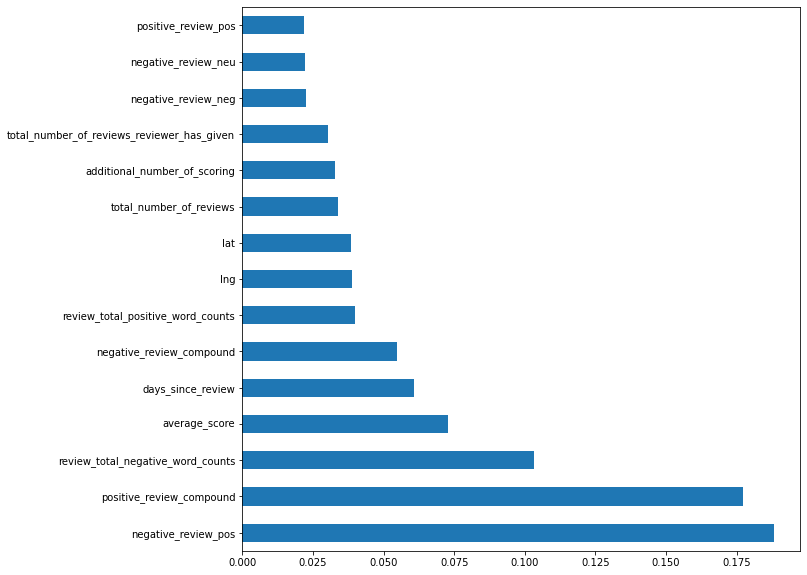

In [152]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [161]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [162]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [163]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [164]:
len(predict_submission), len(sample_submission)

(128935, 128935)

In [165]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.519,488440
1,7.444,274649
2,8.336,374688
3,9.748,404352
4,9.516,451596
5,9.018,302161
6,7.801,317079
7,7.597,13963
8,8.297,159785
9,7.235,195089


# 6. Выводы

Самая лучшая метрика, полученная мной MAPE: 12.38.
Для этого:
- заполнила "0" nan-ы в lat и lng
- обработала признаки с отзывами negative_review и positive_review
- обработала признак days_since_review
- закодировала reviewer_nationality
- кодировка других признаков (hotel_address, hotel_name), логарифмирование нескольких признаков (хотя на графике их распределение стало после этого более нормальное), нормализация MaxMinScaler-ом (из-за выбивающегося days_since_review), удаление коррелирующих между собой признаков и не оказывающих влияния на модель **ухудшили** метрику!